In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy import signal, fft
import timeit

In [179]:
# Message specification
fs = .5e6
sps = 4
Tsym = 1/(fs/sps)

print(f"Symbol Time {Tsym} and Symbol Freq {1/Tsym}")

preamble = [0xAA, 0xAA, 0xAA, 0xAA]
syncword = [0xE2,0xD7]     #Look at gold and hadamard codes

Symbol Time 8e-06 and Symbol Freq 125000.0


## Packetize & Modulate Message

In [182]:
def packetize(preamble, syncword, data):
    #output = bytes(preamble) + struct.pack("<BB", syncword, len(data)) + bytes(data, 'utf-8')
    output = bytes(preamble) + bytes(syncword) + bytes([len(data)]) + bytes(data, 'utf-8')
    output = np.frombuffer(output, np.uint8)
    return output

In [183]:
packet = packetize(preamble, syncword, "Biscuit does white collar crimes")
#packet = np.insert(packet, [0], packet[0])
print(packet)
for byte in packet:
    print(hex(byte))


[170 170 170 170 226 215  32  66 105 115  99 117 105 116  32 100 111 101
 115  32 119 104 105 116 101  32  99 111 108 108  97 114  32  99 114 105
 109 101 115]
0xaa
0xaa
0xaa
0xaa
0xe2
0xd7
0x20
0x42
0x69
0x73
0x63
0x75
0x69
0x74
0x20
0x64
0x6f
0x65
0x73
0x20
0x77
0x68
0x69
0x74
0x65
0x20
0x63
0x6f
0x6c
0x6c
0x61
0x72
0x20
0x63
0x72
0x69
0x6d
0x65
0x73


In [184]:
def unpack_bits(packet, sps):
    #create bit string
    bit_array = np.unpackbits(packet, bitorder='big')
    return np.repeat(bit_array, sps)
unpacked = unpack_bits(packet, sps)

In [185]:
def psk_mod(data, symbol_map):
    return symbol_map[data]

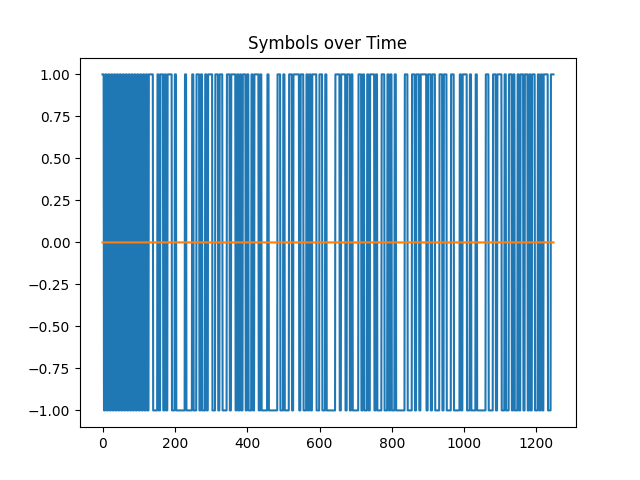

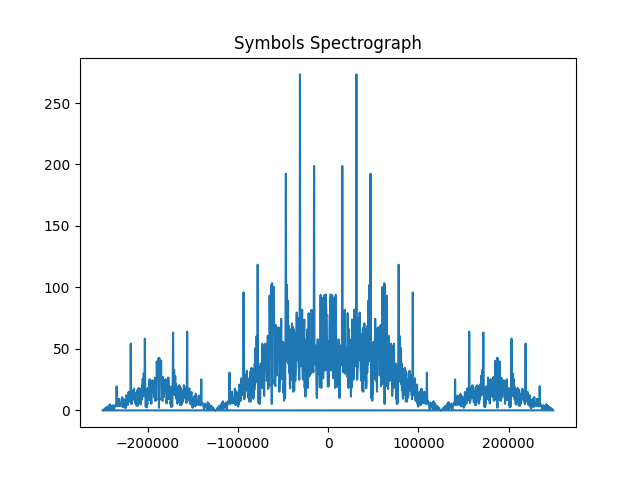

In [186]:
#bpsk_symbol_dict = {0:-1+0j, 1:1+0j}
bpsk_symbol_map = np.array([-1+0j, 1+0j])
symbols = psk_mod(unpacked, bpsk_symbol_map)

%matplotlib widget
plt.figure("Symbols over Time")
plt.title("Symbols over Time")
plt.plot(symbols.real)
plt.plot(symbols.imag)
plt.show()

yf = fft.fft(symbols)
freqs = fft.fftfreq(symbols.size, d=1/fs)

plt.figure("Symbols Spectrograph")
plt.title("Symbols Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

## Root Raised Cosine Filter
You can see that from the Symbols Spectrograph that the frequency response of this signal occupies a large bandwidth with the center lobe going from -1Mhz to +1Mhz. This corelates to -1/Ts and +1/Ts. As a result we should filter frequencies greater than +/- 1/Ts. 

The raised cosine filter does this. The RRC is derived from the sinc function (boxcar filter) and consists of 1/2 cycles of cos on either side. 

The raised cos filter is designed such that it decays to 0 in the time domain with minimal number of taps. 


63
Tsymbol 4


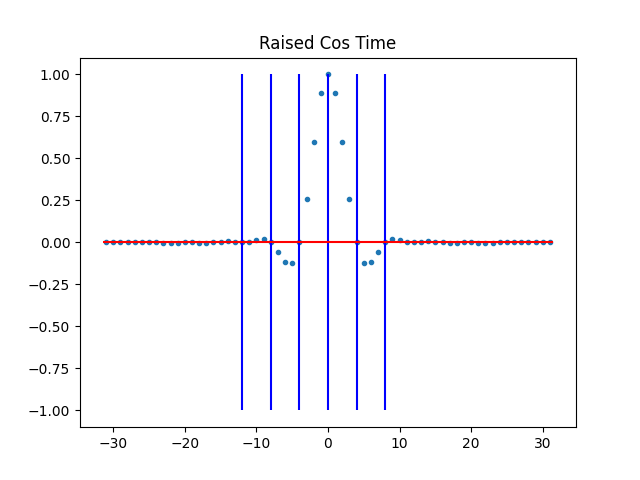

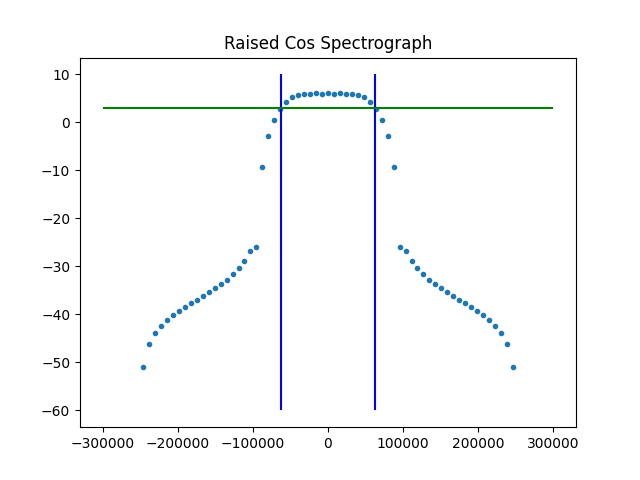

3dB attenuation at +/ Ts/2 or 62500.0


In [187]:
#Design Raised Cosine filter

ntaps = 16*sps - 1
print(ntaps)
n = np.arange(ntaps) - (ntaps-1)//2
beta = .51
Tsymbol = sps
print(f"Tsymbol {Tsymbol}")

if Tsymbol/(2*beta) in n:
    print("Filter has a tap that will result in divide by zero error")
    print(np.where(n==T/(2*beta)))
else:
    root_raised = np.cos(np.pi*beta*n/Tsymbol)*np.sinc(n/Tsymbol)/(1-(2*beta*n/Tsymbol)**2)



%matplotlib widget
plt.close('all')
plt.figure("Raised Cos over Time")
plt.title("Raised Cos Time")
plt.plot(n, root_raised, '.')
plt.vlines(np.arange(-3*sps, 3*sps, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show()

yf = fft.fft(root_raised)
freqs = fft.fftfreq(root_raised.size, d=1/fs)

%matplotlib widget
plt.figure("Raised Cos Spectrograph")
plt.title("Raised Cos Spectrograph")
plt.plot(freqs, 10*np.log10(np.abs(yf)), '.')
plt.vlines([fs/sps/2, -fs/sps/2], -60, 10, 'b')
plt.hlines([3], -30e4, 30e4, 'g')
plt.show()

print(f"3dB attenuation at +/ Ts/2 or {fs/sps/2}")

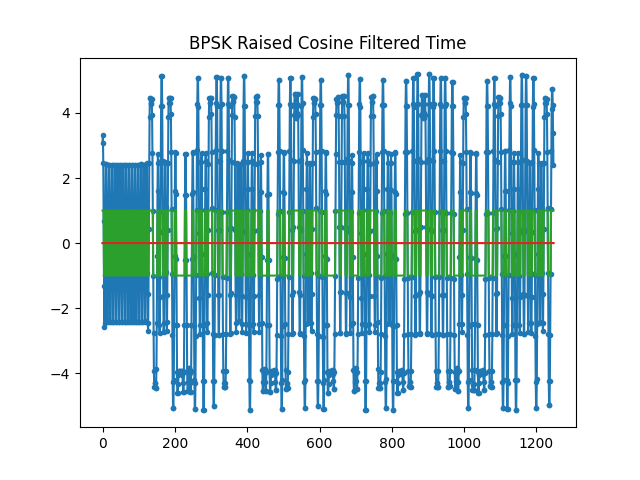

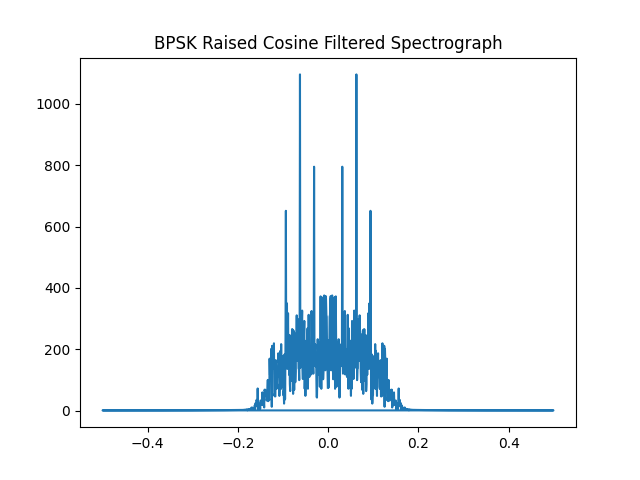

In [188]:
#Now try it on the modulated signal and see what happens
raised_cos_filtered = signal.convolve(symbols, root_raised, mode='same')


%matplotlib widget
plt.figure("BPSK Raised Cosine Filtered Time")
plt.title("BPSK Raised Cosine Filtered Time")
plt.plot(raised_cos_filtered.real, '.-')
plt.plot(raised_cos_filtered.imag)
plt.plot(symbols.real)
plt.plot(symbols.imag)

plt.show()

yf = fft.fft(raised_cos_filtered)
freqs = fft.fftfreq(raised_cos_filtered.size)

plt.figure("BPSK Raised Cosine Filtered Spectrograph")
plt.title("BPSK Raised Cosine Filtered Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

Correct BW: 0.51


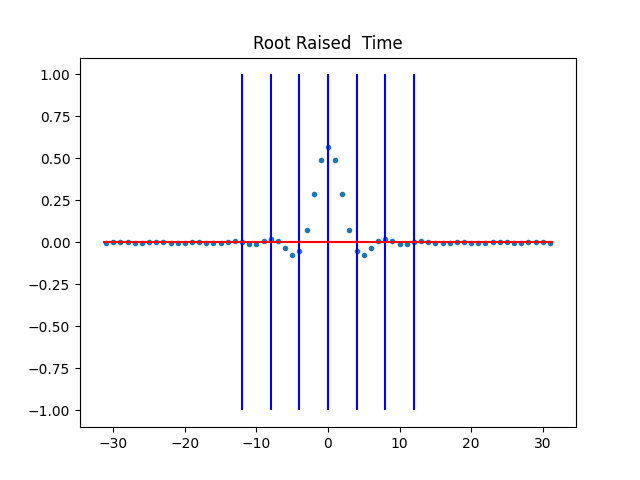

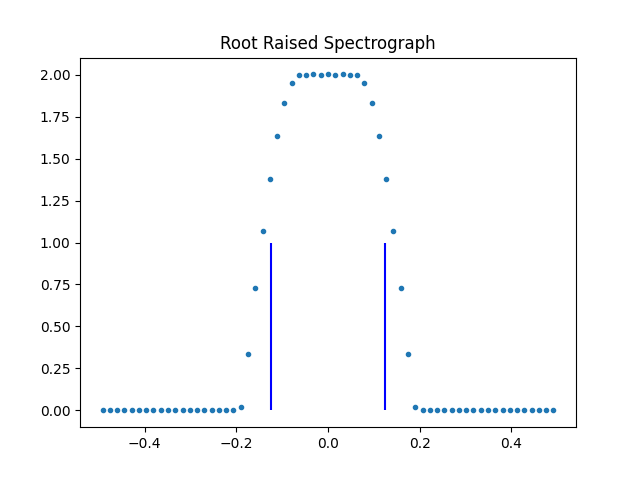

In [189]:
# Now make the raised cosine filter. This is done to create a matched filter for the tx and rx sides. 
#Note that the impulse response is non-zero @ +/Tsym for the Root Raised cos filter unlike the Raised Cos filter.
def rootRaisedCos(ntaps, sps, excess_bw):
    n = np.arange(ntaps) - (ntaps-1)//2

    #avoid divide by 0 issue in rrc equation due to excess BW collision
    while sps/(4*excess_bw) in n:
        excess_bw += .001

    a = excess_bw
    print(f"Correct BW: {a}")
    
    #Gracefully ignore divide by 0 when n=0
    with np.errstate(divide='ignore', invalid='ignore'):
        rrc = np.cos(np.pi*(1+a)*n/sps) + sps/(4*a*n) * np.sin(np.pi*(1-a)*n/sps)
        rrc *= 4*a/(np.pi*np.sqrt(sps)) / (1 - (4*a*n/sps)**2)
        
    #Handle divide by zero condition when n=0
    rrc[np.argwhere(np.isnan(rrc))] = (1+a*(4/np.pi-1))/np.sqrt(sps)
    
    return n, rrc

n, rrc = rootRaisedCos(ntaps, sps, .51)

%matplotlib widget
plt.close('all')
plt.figure("Root Raised over Time")
plt.title("Root Raised  Time")
plt.plot(n, rrc, '.')
plt.vlines(np.arange(-3*sps, 3*sps+1, sps), -1, 1, 'b')
plt.hlines(0, -ntaps/2, ntaps/2, 'r')
plt.show()

yf = fft.fft(rrc)
freqs = fft.fftfreq(rrc.size)

plt.figure("Root Raised Spectrograph")
plt.title("Root Raised Spectrograph")
plt.plot(freqs, np.abs(yf), '.')
plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()

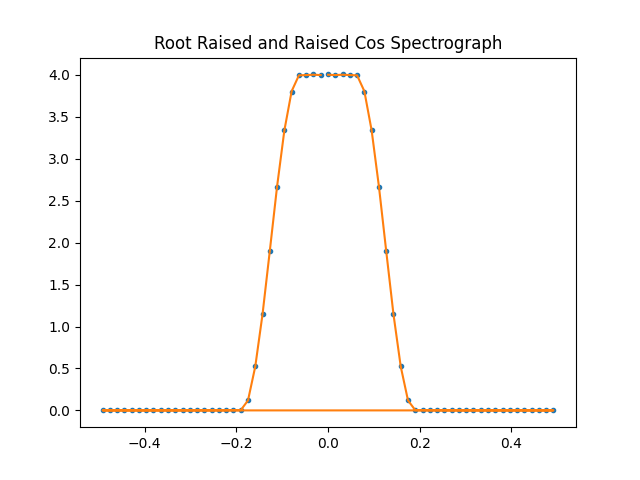

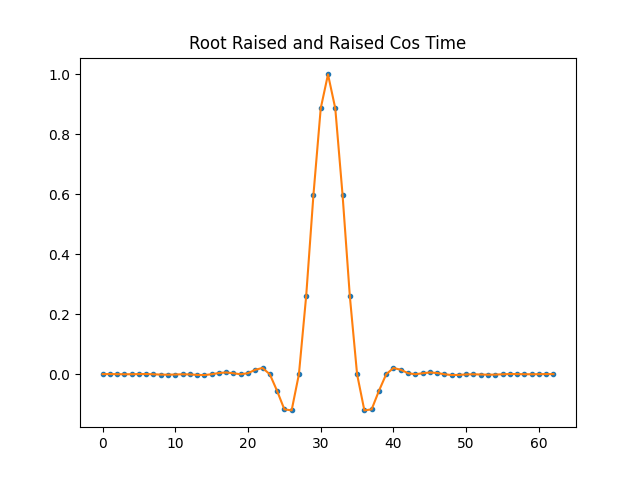

In [190]:
#Verify that 2 RRC is equal to a raised cos filter. This is to check that the algorithm is correct
rrc2 = signal.convolve(rrc, rrc, mode='same')

%matplotlib widget
plt.close('all')
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(rrc2, '.')
plt.plot(root_raised, '-')
plt.show

yf_rrc2 = fft.fft(rrc2)
freqs_rrc2 = fft.fftfreq(rrc2.size)

yf_rc = fft.fft(root_raised)
freqs_rc = fft.fftfreq(root_raised.size)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs_rrc2, np.abs(yf_rrc2), '.')
plt.plot(freqs_rc, np.abs(yf_rc), '-')
#plt.vlines([1/sps/2, -1/sps/2], 0, 1, 'b')
plt.show()



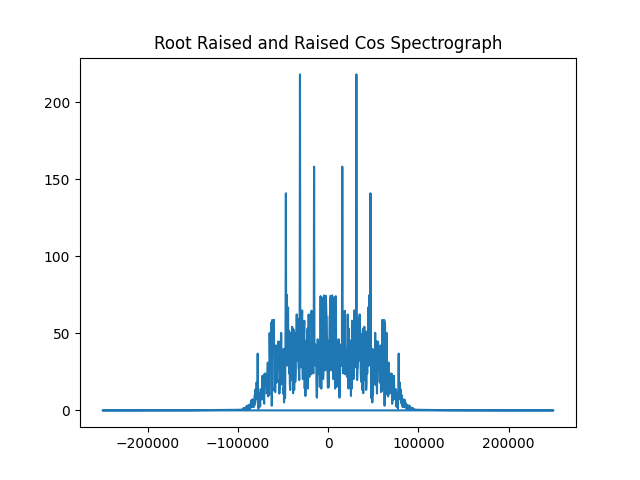

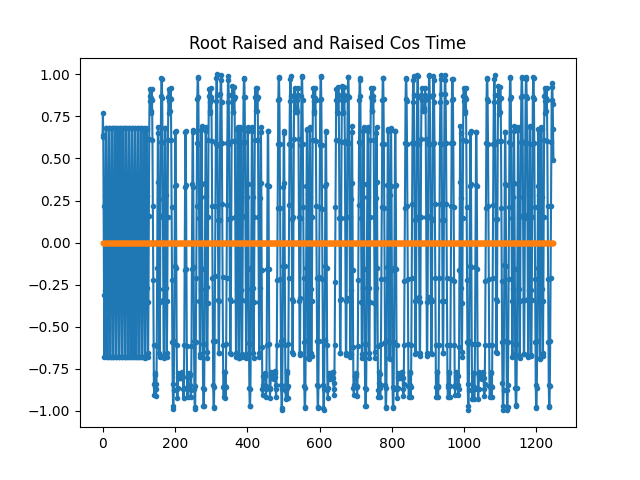

In [191]:
# apply RRC to modulated signal. This is the transmitted signal.
#symbols2 = np.concatenate([np.zeros(500*2), symbols, np.zeros(500*2)])
tx_waveform = signal.convolve(symbols, rrc, mode='same')
tx_waveform /= np.max(np.abs(tx_waveform))

%matplotlib widget
plt.close('all')
plt.figure("Root Raised and Raised Cos over Time")
plt.title("Root Raised and Raised Cos Time")
plt.plot(tx_waveform.real, '.-')
plt.plot(tx_waveform.imag, '.-')
plt.show

yf = fft.fft(tx_waveform)
freqs = fft.fftfreq(tx_waveform.size, d=1/fs)

plt.figure("Root Raised and Raised Cos Spectrograph")
plt.title("Root Raised and Raised Cos Spectrograph")
plt.plot(freqs, np.abs(yf))
plt.show()

## Channel Modeling
Now that we have the transmit waveform, we need to model how the signal will look like once it arrives at the receiver. The following factors need to be taken into account:
1. Additive White Gaussian Noise (AWGN). Take a signal to noise parameter to determine how much noise to add
2. Frequency offset. This is to model clock disparaties b/t the transmitter and receiver.
3. Phase offset. The signal will arrive at the receiver at an unknown period in time

Tx Variance 0.45579535153438133
Max Noise voltage so that SNR < 10dB 0.045579535153438135
63
Noise power: 1.0394616119011342


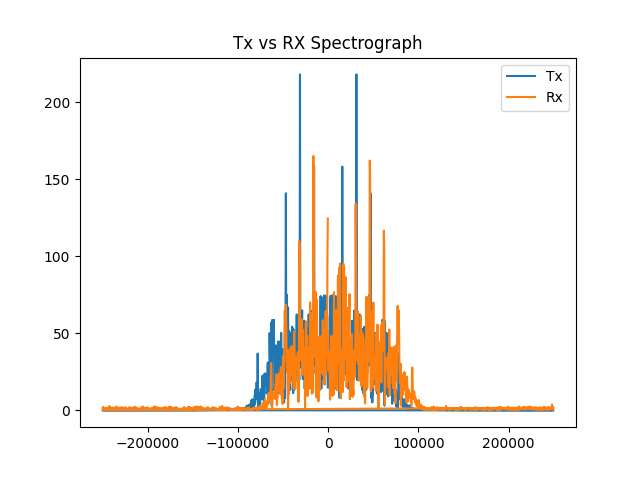

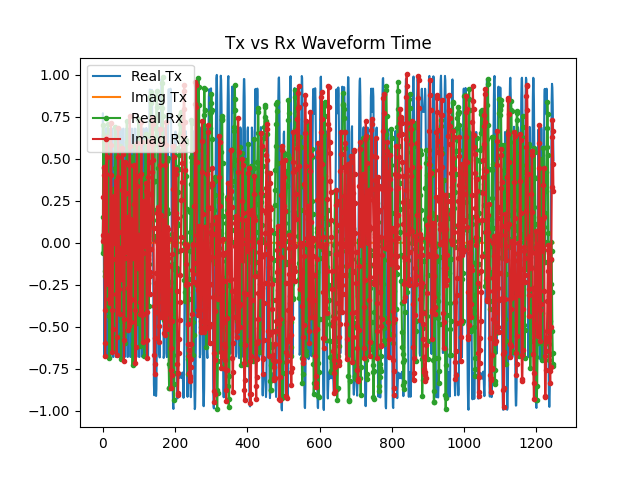

In [192]:
# Model Channel
def channel_model(input_sig, noise_voltage, fractional_samp_delay, samp_rate, freq_offset, padding):
    
    #Add fractional sample delay/phase offset using Whittaker–Shannon interpolation formula (https://tomroelandts.com/articles/how-to-create-a-fractional-delay-filter)
    N = 2**6 - 1 # Number of taps. This number was semi-arbitrarily picked 
    print(N)
    n = np.arange(-N//2, N//2) # 0 Center taps
    h = np.sinc(n-fractional_samp_delay)
    h *= np.hamming(N) #Window filter to ensure it decays to 0
    h /= np.sum(h)     #Normalize filter so there's 0dB gain

    phase_shifted = signal.convolve(input_sig, h, mode='same')

    # Frequency offset
    t = np.linspace(0, 1/samp_rate*len(input_sig), len(input_sig))
    freq_shifted = phase_shifted * np.exp(2j*np.pi*freq_offset*t)

    #Add

    #Add AWGN
    noise = (np.random.randn(len(freq_shifted)) + 1j*np.random.randn(len(freq_shifted)))/np.sqrt(2)
    print(f"Noise power: {np.var(noise)}")
    output_sig = freq_shifted + noise_voltage*noise
    
    return output_sig



print(f"Tx Variance {np.var(tx_waveform)}")
max_noise = np.var(tx_waveform)/(10)
print(f"Max Noise voltage so that SNR < 10dB {max_noise}")

rx_waveform = channel_model(tx_waveform, max_noise*.7, .7, fs, 15e3, 0)

%matplotlib widget
plt.figure("Tx vs Rx Waveform Time")
plt.title("Tx vs Rx Waveform Time")
plt.plot(tx_waveform.real)
plt.plot(tx_waveform.imag)
plt.plot(rx_waveform.real, '.-')
plt.plot(rx_waveform.imag, '.-')

plt.legend(['Real Tx', 'Imag Tx', 'Real Rx', 'Imag Rx'])
plt.show

rx_yf = fft.fft(rx_waveform)
rx_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)

tx_yf = fft.fft(tx_waveform)
tx_freqs = fft.fftfreq(tx_waveform.size, d=1/fs)

plt.figure("Tx vs RX Spectrograph")
plt.title("Tx vs RX Spectrograph")
plt.plot(tx_freqs, np.abs(tx_yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.legend(['Tx', 'Rx'])
plt.show()


In [193]:
# PUll 1 burst from real world receive
#rx_waveform = np.fromfile("usrp_rx_shift_LPF_1burst.iq", np.complex64)

## Demodulate
Demodulation will consist of 
1. Coarse Frequency Syncronization. This can be done using:
    * FLL Band-edge
    * M'th power law
2. Apply Root Raised Cosine Filter (LPF & Matched Filter)
4. Timing Synchronization. This can be done by:
    * Polyphase clock recovery Correlating on the syncword after the syncword has been passed through a raised cosine filter. (I think this will be computationally intensive)
    * PLL Based Syncronization
        * Drive derivative of matched filter to zero (min of 2 SPS)
            * maximum likelihood
            * early late 
        * Aligning one of the samples w/ zero crossings (min of 2 SPS)
            * zero crossing
            * Gardner
        * Mueller & Mueller (min of 1 sps)
6. Fine Frequency Syncronization
7. Demodulation
8. De-packetization

Per [fred harris](https://www.youtube.com/watch?v=Zmjk9NE-3k0) Band edge filtering can be used to determine both carrier and phase offset (Timing & Freq Sync)

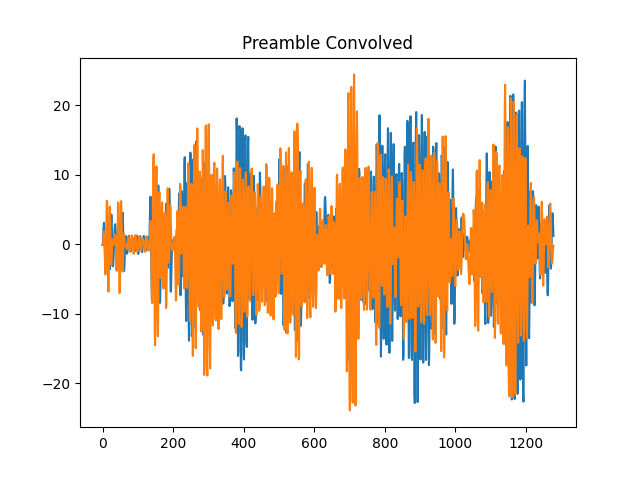

[ 44175.13682565  50039.09304144  56293.97967162  57857.70132916
  58248.63174355  58639.56215794  59030.49257232  59421.42298671
  59812.35340109  60203.28381548  60594.21422987  60985.14464425
  61376.07505864  61767.00547303  62157.93588741  62548.8663018
  63330.72713057  63721.65754496  64112.58795934  64503.51837373
  64894.44878812  65285.3792025   65676.30961689  66067.24003127
  67240.03127443  67630.96168882 -63330.72713057 -62939.79671618]


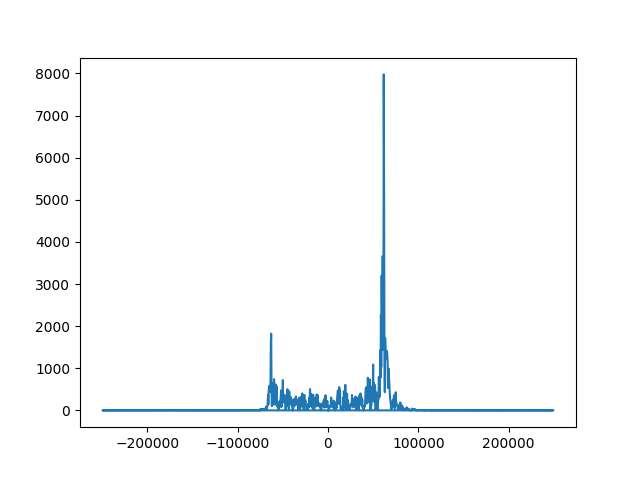

In [141]:
# Coarse frequency correction using preamble and FLL band edge - incomplete
preamble = unpack_bits(np.array([0xAA,0xAA], np.uint8), sps)
preamble = psk_mod(preamble, bpsk_symbol_map)
preamble = signal.convolve(preamble, rrc, mode='same')

matched = signal.convolve(preamble, rx_waveform)

%matplotlib widget
plt.figure("Preamble Convolved")
plt.title("Preamble Convolved")
plt.plot(matched.real)
plt.plot(matched.imag)
plt.show()

yf = fft.fft(matched)
freqs = fft.fftfreq(matched.size, d=1/fs)
print(freqs[np.abs(yf)>750])

plt.figure("Preamble Convolved vs RX")
plt.plot(freqs, np.abs(yf))
#plt.plot(rx_freqs, np.abs(rx_yf))
#plt.legend(['Preamble', 'Unfiltered Rx'])
plt.show()

Freq offset: 15024.038461538461
D Freq offset: 15024.038461538461


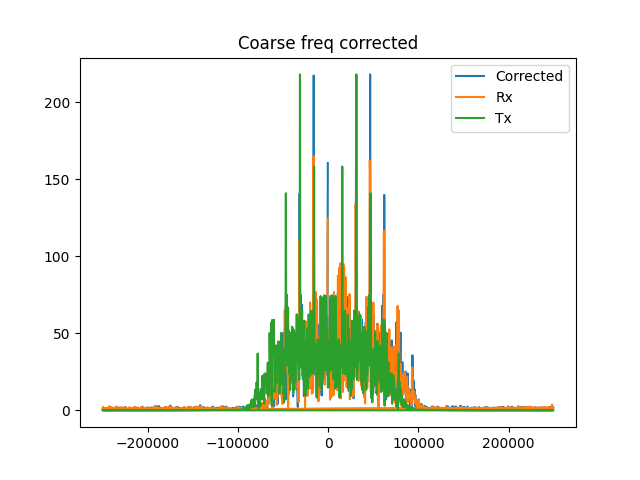

In [194]:
# Coarse frequency correction using M-th power law described in pysdr and pg. 517 of Principles of Communications
corrected_yf = fft.fft(rx_waveform**2)
corrected_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)
freq_offset = corrected_freqs[np.argmax(np.abs(corrected_yf))]/2
print(f"Freq offset: {freq_offset}")


# Computationally simplified
nfft = 2^15
d_corrected_yf = fft.fft(rx_waveform**2, nfft)
d_corrected_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)
d_freq_offset = corrected_freqs[np.argmax(np.abs(d_corrected_yf))]/2
print(f"D Freq offset: {freq_offset}")

d_freq_offset_time = np.arange(len(rx_waveform))/fs
coarse_freq_corr = rx_waveform*np.exp(2j*np.pi*d_freq_offset*d_freq_offset_time)

%matplotlib widget
plt.close('all')

rx_yf = fft.fft(rx_waveform)
rx_freqs = fft.fftfreq(rx_waveform.size, d=1/fs)

corrected_yf = fft.fft(coarse_freq_corr)
corrected_freqs = fft.fftfreq(coarse_freq_corr.size, d=1/fs)

plt.figure("Coarse freq corrected Spectrograph")
plt.title("Coarse freq corrected")
plt.plot(corrected_freqs, np.abs(corrected_yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.plot(tx_freqs, np.abs(tx_yf))

plt.legend(['Corrected', 'Rx', 'Tx'])
plt.show()

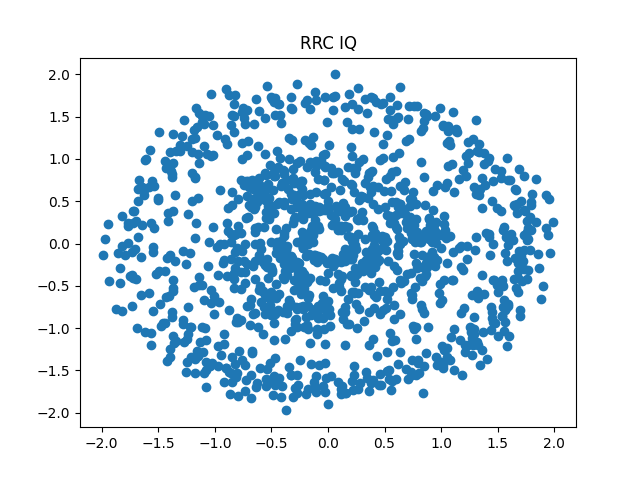

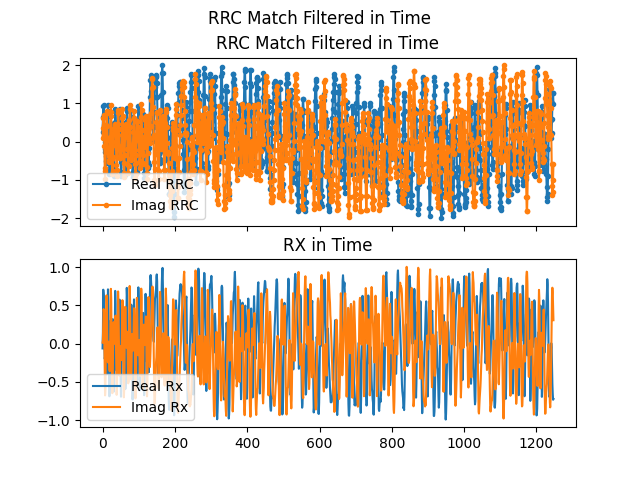

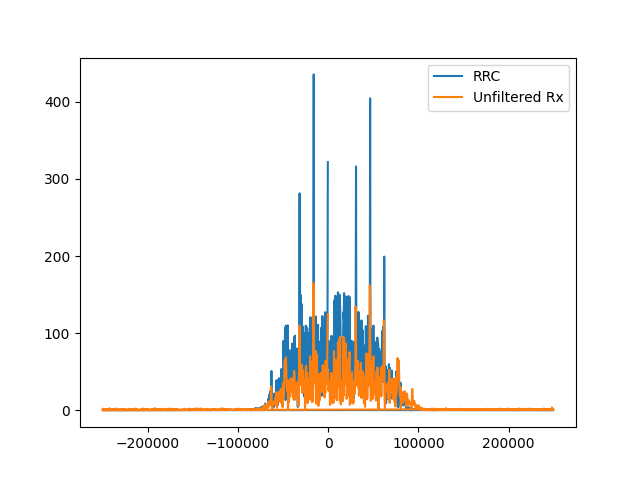

In [195]:
# Apply RRC
rrc_match_filtered = signal.convolve(coarse_freq_corr, rrc, mode='same')

%matplotlib widget
fig, ax = plt.subplots(2, sharex=True)
fig.suptitle("RRC Match Filtered in Time")
ax[0].set_title("RRC Match Filtered in Time")
ax[0].plot(rrc_match_filtered.real, '.-')
ax[0].plot(rrc_match_filtered.imag, '.-')
ax[0].legend(['Real RRC', 'Imag RRC'])

ax[1].set_title("RX in Time")
ax[1].plot(rx_waveform.real)
ax[1].plot(rx_waveform.imag)

plt.legend(['Real Rx', 'Imag Rx'])


yf = fft.fft(rrc_match_filtered)
freqs = fft.fftfreq(rrc_match_filtered.size, d=1/fs)

plt.figure("RRC Match Filtered Spectrum vs RX")
plt.plot(freqs, np.abs(yf))
plt.plot(rx_freqs, np.abs(rx_yf))
plt.legend(['RRC', 'Unfiltered Rx'])

plt.figure("RRC IQ")
plt.title("RRC IQ")
plt.scatter(rrc_match_filtered.real, rrc_match_filtered.imag)
plt.show()

1145
112.0


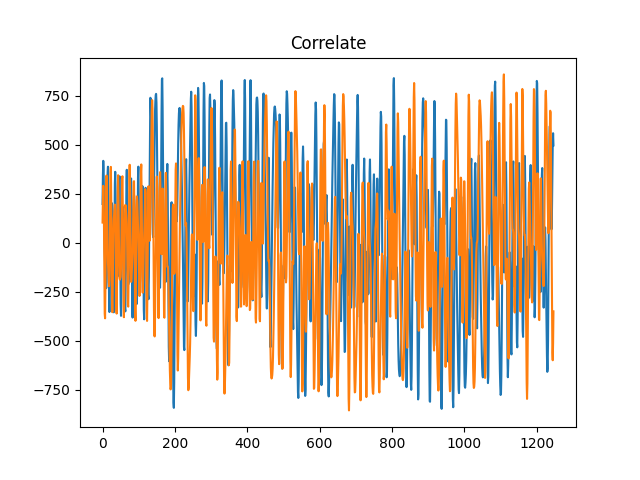

In [196]:
# Time Sync - I'm going to try doing this by correlating with the syncword
syncword_bits = unpack_bits(np.array(syncword, np.uint8), sps)
syncword_mod = psk_mod(syncword_bits, bpsk_symbol_map)
syncword_mod = signal.convolve(syncword_mod, rrc, mode='same')
syncword_mod = signal.convolve(syncword_mod, rrc, mode='same')


correlate = signal.correlate(rrc_match_filtered, syncword, mode='valid')

print(np.argmax(np.abs(correlate)))
print(sps*3*8+sps*8/2)

%matplotlib widget
plt.figure("Correlate")
plt.title("Correlate")
plt.plot(correlate.real)
plt.plot(correlate.imag)
plt.show()


128


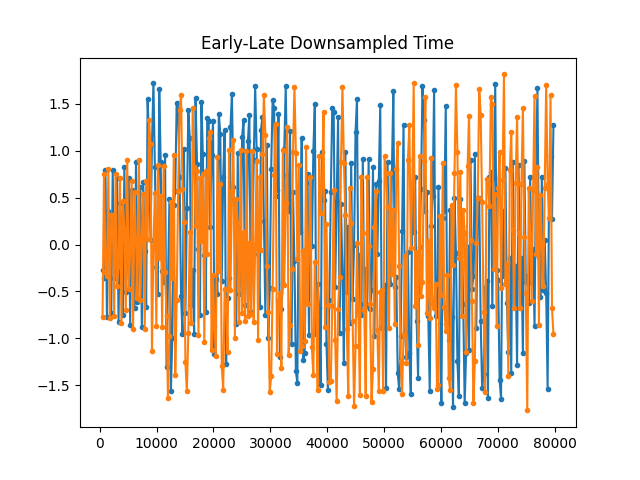

[0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1
 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1
 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0
 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0
 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1
 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0
 0 1 1 0 0 1 0 1 0 0 1 1 1 1]


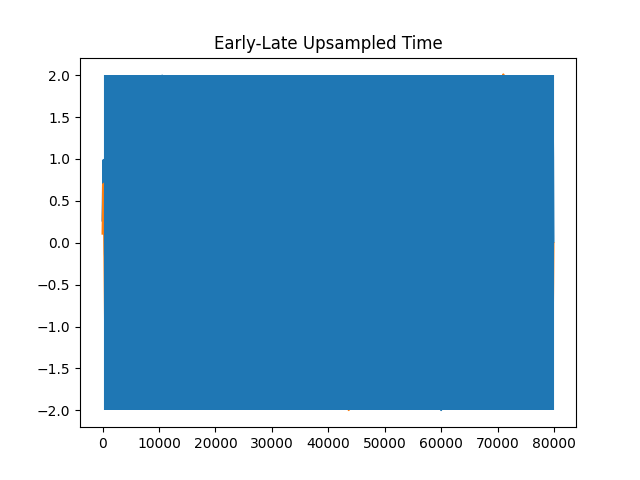

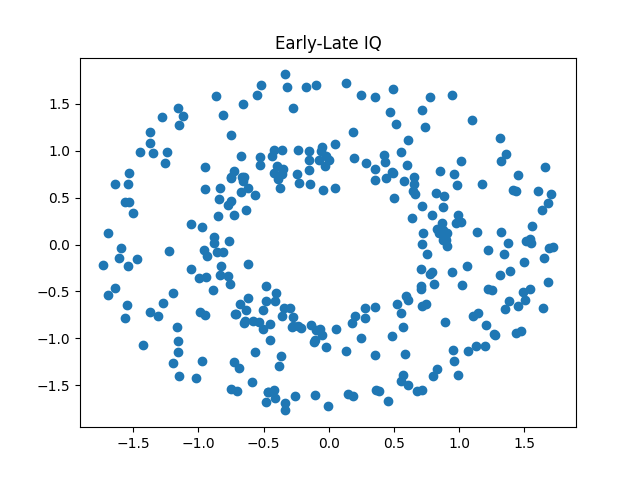

In [197]:
# Time Sync - Early-Late
#TODO need to test for SNR performance and time to timing lock
interp_factor = 64  #Arbitrarily chosen 
interp_signal = signal.resample_poly(rrc_match_filtered, interp_factor, 1)
interp_sps = sps*interp_factor

i = interp_sps
i_out = 0
new_sample_pts = np.zeros(np.shape(interp_signal), int) - 1
phase_offset = 0
dt = int(interp_sps/2)
print(dt)
while i + interp_sps < len(interp_signal):
    phase_offset = np.abs(interp_signal[i]) * (np.abs(interp_signal[i-dt]) - np.abs(interp_signal[i+dt]))
    #print(phase_offset)
    i += int(interp_sps + phase_offset.real)
    
    new_sample_pts[i_out] = i
    i_out += 1

early_late_out = interp_signal[new_sample_pts[:i_out]]
%matplotlib widget
plt.figure("Early-Late Upsampled Time")
plt.title("Early-Late Upsampled Time")
plt.plot(interp_signal.real)
plt.plot(interp_signal.imag)
plt.vlines(new_sample_pts[:i_out], -2, 2)

plt.figure("Early-Late IQ")
plt.title("Early-Late IQ")
plt.scatter(early_late_out.real, early_late_out.imag)

plt.figure("Early-Late Downsampled Time")
plt.title("Early-Late Downsampled Time")
plt.plot(new_sample_pts[:i_out], early_late_out.real, '.-')
plt.plot(new_sample_pts[:i_out], early_late_out.imag, '.-')
plt.show()

#print(np.packbits([early_late_out[1:]>0]*1) == packet)
print((early_late_out[1:]>0)*1)

128


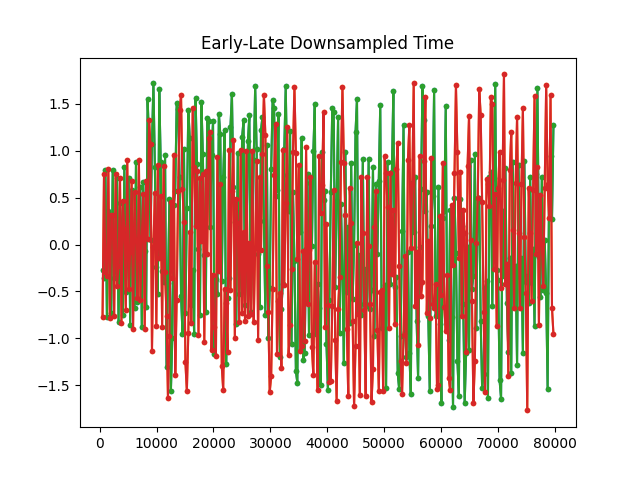

[0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0
 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1
 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1
 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0
 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0
 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1
 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0
 0 1 1 0 0 1 0 1 0 0 1 1 1 1]


In [198]:
# Time Sync - Mueller & Mueller
#TODO need to test for SNR performance and time to timing lock
interp_factor = 64  #Arbitrarily chosen 
interp_signal = signal.resample_poly(rrc_match_filtered, interp_factor, 1)
interp_sps = sps*interp_factor

i = interp_sps
i_out = 0
new_sample_pts = np.zeros(np.shape(interp_signal), int) - 1
phase_offset = 0
dt = int(interp_sps/2)
print(dt)
while i + interp_sps < len(interp_signal):
    phase_offset = np.abs(interp_signal[i]) * (np.abs(interp_signal[i-dt]) - np.abs(interp_signal[i+dt]))
    #print(phase_offset)
    i += int(interp_sps + phase_offset.real)
    new_sample_pts[i_out] = i
    i_out += 1

early_late_out = interp_signal[new_sample_pts[:i_out]]
%matplotlib widget
plt.figure("Early-Late Upsampled Time")
plt.title("Early-Late Upsampled Time")
plt.plot(interp_signal.real)
plt.plot(interp_signal.imag)
plt.vlines(new_sample_pts[:i_out], -2, 2)

plt.figure("Early-Late IQ")
plt.title("Early-Late IQ")
plt.scatter(early_late_out.real, early_late_out.imag)

plt.figure("Early-Late Downsampled Time")
plt.title("Early-Late Downsampled Time")
plt.plot(new_sample_pts[:i_out], early_late_out.real, '.-')
plt.plot(new_sample_pts[:i_out], early_late_out.imag, '.-')
plt.show()

#print(np.packbits([early_late_out[1:]>0]*1) == packet)
print((early_late_out[1:]>0)*1)

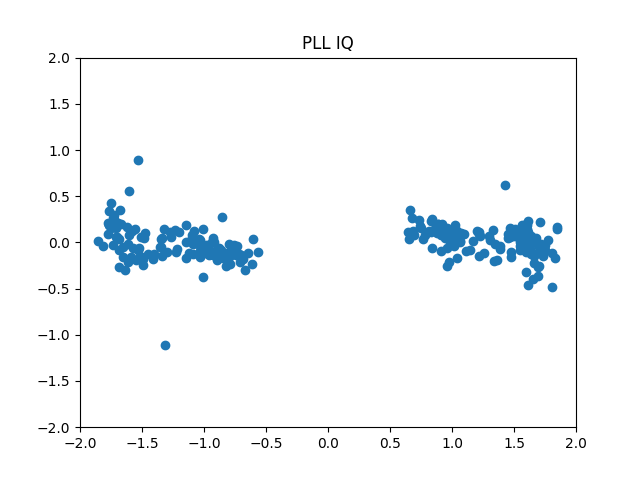

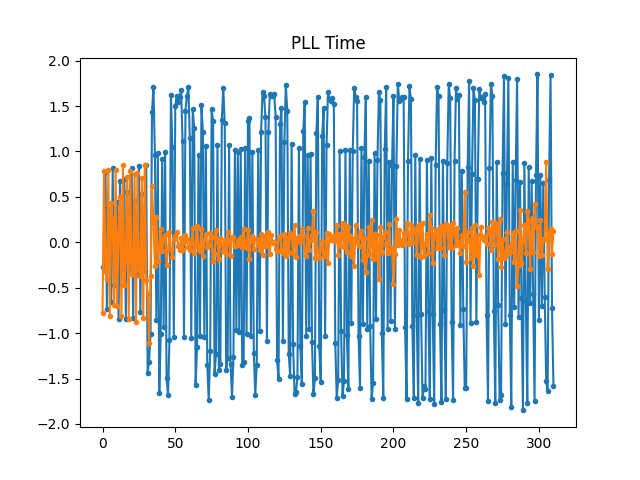

In [199]:
# Fine frequency syncronization using PLL/costas loop

pll_in = early_late_out
pll_phase = 0
pll_freq = 0
alpha = .3  #frequency error gain
beta = .2 #phase error gain
freq_log = []

pll_out = np.zeros(len(pll_in), dtype=complex)

for i in range(len(pll_in)):
    pll_out[i] = pll_in[i] * np.exp(-1j*pll_phase)
    error = pll_out[i].real * pll_out[i].imag   #Error formula for 2nd order costas loop (BPSK)
    #print(f"Error {error}")

    #Update loop 
    pll_freq += (beta * error)
    freq_log.append(pll_freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    pll_phase += pll_freq + (alpha * error)

    pll_phase = np.fmod(pll_phase, 2*np.pi)    
    i+=1

%matplotlib widget
plt.close('all')
plt.figure("PLL IQ")
plt.title("PLL IQ")
plt.scatter(pll_out[8*4:].real, pll_out[8*4:].imag)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

plt.figure("PLL Time")
plt.title("PLL Time")
plt.plot(pll_out.real, '.-')
plt.plot(pll_out.imag, '.-')
plt.show()

In [200]:
#Demodulate
#bits = (early_late_out > 0)*1
bits = (pll_out > 0)*1
print(bits)

[0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1
 0 1 0 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0
 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1
 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1
 1 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0
 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0
 0 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1
 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0]


In [207]:
# Depacketize
# Correlate Preamble

syncword_bits = unpack_bits(np.array([syncword], np.uint8), 1)

syncword_bits_inv = (~(syncword_bits>0))*1 #^ syncword_bits
bits_inv = (~(bits>0))*1
print(f"Syncword Bits {syncword_bits}, {type(syncword_bits)}")
print(f"Synword bits Inverted {syncword_bits_inv} {type(syncword_bits_inv)}")
sync_corr = signal.correlate(bits, syncword_bits, mode='valid')
sync_corr_inv = signal.correlate(syncword_bits_inv, bits, mode='valid')

print(np.max(sync_corr))
print(sync_corr)

print(np.max(sync_corr_inv))
print(sync_corr_inv)
#TODO need to make sure that max(sync_corr) is equal to the power of the syncword (6 for 11010111)
pkt_start = np.argmax(sync_corr) + int(len(syncword_bits)/2)
print(bits[pkt_start:])
print(sync_corr)
packet = np.packbits(bits[pkt_start:])
packet_len = packet[0]
print(packet_len)
message = packet[1:packet_len+1]
print(message.tobytes())

Syncword Bits [1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1], <class 'numpy.ndarray'>
Synword bits Inverted [0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0] <class 'numpy.ndarray'>
9
[3 6 5 5 6 3 5 5 4 6 3 5 4 3 5 3 5 3 2 5 4 6 4 4 4 5 4 5 5 4 5 0 5 5 6 6 5
 6 5 7 6 7 7 6 7 7 8 7 7 8 6 8 7 7 7 6 5 7 6 3 7 5 6 4 3 4 4 5 6 6 5 4 2 5
 5 4 5 3 5 3 4 4 6 4 4 5 4 6 2 5 4 3 6 4 5 5 5 5 6 6 6 9 6 8 6 6 6 6 8 8 8
 7 7 6 7 6 7 7 4 4 3 5 4 3 6 5 5 4 4 4 5 1 4 5 4 4 3 6 5 6 5 7 6 7 5 6 7 5
 6 5 6 4 5 4 5 5 5 6 5 6 3 6 4 4 5 5 6 6 4 5 5 3 8 5 6 5 5 4 5 5 6 7 5 5 4
 5 6 5 7 9 6 8 6 7 7 6 7 8 7 6 5 6 6 6 7 5 4 3 2 5 5 3 4 2 3 5 4 5 4 2 4 4
 4 6 5 5 4 3 7 8 7 6 5 5 5 3 7 7 6 5 4 7 6 8 6 8 7 7 6 6 7 6 8 8 8 6 5 6 6
 5 7 6 6 4 4 6 5 6 4 5 6 5 3 5 5 4 7 4 5 5 3 4 5 3 7 5 4 5 4 4 5 2 5 6 4 4]
6
[3 3 2 2 4 2 3 3 2 3 2 1 4 2 3 4 2 3 3 1 5 3 3 5 3 2 2 3 2 3 2 4 4 2 3 2 4
 4 4 6 5 4 4 4 6 4 5 5 4 3 2 4 2 4 3 5 4 3 3 2 5 4 4 4 3 3 2 2 5 4 3 3 2 3
 2 2 4 2 1 2 1 2 2 1 3 1 1 4 3 3 3 2 4 4 4 6 5 4 4 4 5 4 4 5 3 5 2 3 5 3 4
 4 3 3 1 3 3 3 4 

# Let's Try Processing a Real Received Signal